# Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [113]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [36]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [37]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [103]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

# Analyse descriptive

Regardons la structure de la table:

In [104]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0188399313,"[0, 0]",5,"They work very well. Easy to clean, we wash th...","05 27, 2013",A28O3NP6WR5517,Jennifer gymer,These bottles are great!,1369612800
1,0188399399,"[1, 1]",5,it came early and was not disappointed. i love...,"04 9, 2013",AX0M1Z6ZWO52J,Ash M.,perfect,1365465600
2,0188399518,"[0, 0]",4,I ended up with a variety of different brands ...,"02 14, 2014",A1KD7N84L7NIUT,Buffy Fan,Good cotton wipes,1392336000
3,0188399518,"[1, 1]",3,"These flannel wipes are OK, but in my opinion ...","07 8, 2013",A29CUDEIF4X1UO,J. D. Solbach,Sending them back.,1373241600
4,0316967297,"[0, 0]",4,"Cute quilt, the colors are perfect and my litt...","09 6, 2013",A32592TYN6C9EM,Amazon Customer,Very cute,1378425600


Etudions les dimensions clés de la table:

In [105]:
Nbreviews=len(df)
Nbproducts=len(set(df["asin"]))
Nbreviewers=len(set(df["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 915448
Le nombre total de produits est: 64426
Le nombre total de reviewers est: 531891
Soit un nombre moyen de 14.2 reviews par produit
Soit un nombre moyen de 1.7 reviews par reviewers


Analysons la distribution des notes des reviews

count    915448.000000
mean          4.117694
std           1.289457
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64


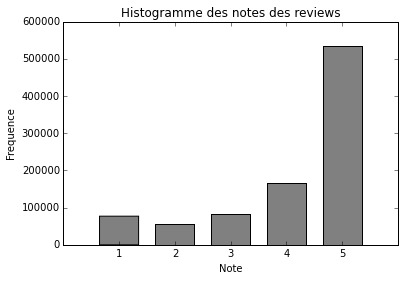

In [106]:
print(df["overall"].describe())
%matplotlib inline 
a=[int(i) for i in df["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Frequence");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

            overall
count  64426.000000
mean       4.062579
std        1.021886
min        1.000000
25%        3.589744
50%        4.333333
75%        5.000000
max        5.000000


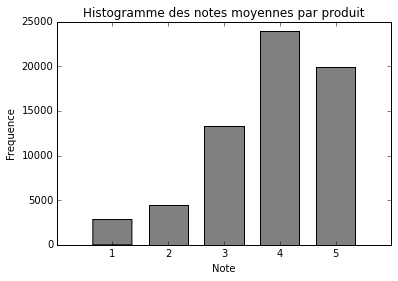

In [107]:
average_note_byproduct=df[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct.describe())
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Frequence");

Regardons la distribution du nombre de reviews par utilisateur.

                   0
count  531891.000000
mean        1.721120
std         2.158474
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       155.000000


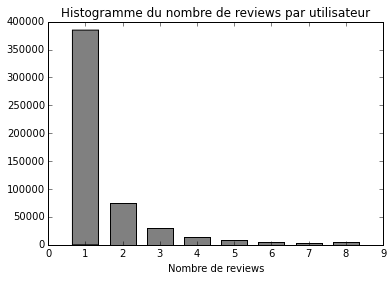

In [109]:
import collections
Nbreview_by_user=collections.Counter(df["reviewerID"])
print(pd.DataFrame(list(Nbreview_by_user.values())).describe())
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("");

Définition de la fonction de comptage du nombre de mots d'une review

In [110]:
import re
def countWords(review):
    return (len(re.findall(r'\w+', review["reviewText"])))

In [111]:
df["countWordsReview"] = df.apply(countWords, axis = 1)

In [114]:
a = df["countWordsReview"]
print(max(a), min(a), stat.median(a), stat.mean(a))

4653 0 56.0 84.2634917549


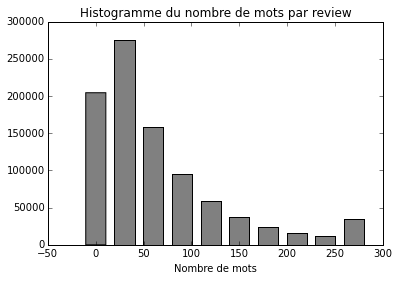

In [115]:
%matplotlib inline 
bins=range(0,330,30)
a = np.clip(df["countWordsReview"], 0, 300)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
##ax.set_xticks(bins[:-1])
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("");

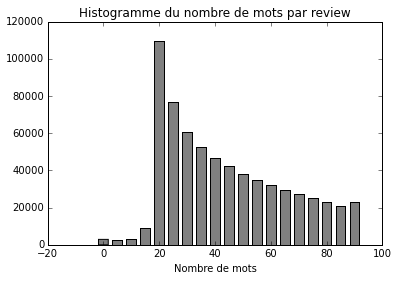

In [116]:
a = [s for s in df["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
##ax.set_xticks(bins[:-1])
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("");

In [ ]:
buf = StringIO()
for i in range(df.shape[0]):
    buf.write(df["reviewText"][i])

# Préparation des données